# GR4J Hydrological Model Optimization

This notebook implements the optimization of the GR4J rainfall-runoff model using Optuna for parameter calibration. The GR4J model (modèle du Génie Rural à 4 paramètres Journalier) is a daily lumped rainfall-runoff model that has been widely used in hydrology.

In [9]:
# Import required libraries
import json
import multiprocessing as mp
import os
import pickle
import sys
from datetime import datetime
from functools import partial
from pathlib import Path

import geopandas as gpd
import numpy as np
import optuna
import pandas as pd
import polars as pl
import xarray as xr
from tqdm.notebook import tqdm

# Ensure we can import from src
sys.path.append(os.path.abspath("../"))

# Import logger setup, models, and metrics
from src.models import gr4j
from src.models.analysis.pareto import (
    analyze_pareto_front,
    save_optimization_results,
    select_best_trial_weighted,
)
from src.models.optimization.gr4j_optuna import (
    early_stopping_callback,
    multi_objective,
    progress_callback,
    run_optimization,
)
from src.models.pet import pet_oudin
from src.utils.logger import setup_logger
from src.utils.metrics import (
    evaluate_model,
)
from src.utils.parallel import run_parallel_optimization

# Create log directories if they don't exist
log_dir = Path("../logs/notebooks")
log_dir.mkdir(parents=True, exist_ok=True)

# Set up logger
logger = setup_logger(
    name="gr4j_model", log_level="INFO", log_file="../logs/notebooks/gr4j_model.log", console_output=True
)

# Set Optuna's default logger to WARNING to reduce output
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Data Preparation

Load and prepare the hydrometeorological data required for the GR4J model:

1. Daily precipitation (mm/day)
2. Daily potential evapotranspiration (mm/day)
3. Daily temperature (°C) for snow module
4. Daily observed discharge (for calibration)

### Read geometry and hydrology series's

In [5]:
# Read watershed and gauge geometry data from GeoPackage files
e_obs_ws = gpd.read_file("../data/Geometry/EOBSWatersheds2025.gpkg", ignore_geometry=False)
e_obs_ws.set_index("gauge_id", inplace=True)
e_obs_gauge = gpd.read_file("../data/Geometry/EOBSPoints2025.gpkg", ignore_geometry=False)
e_obs_gauge.set_index("gauge_id", inplace=True)

full_gauges = []
partial_gauges = []

for gauge_id in e_obs_ws.index:
    hydro_file = pd.read_csv(
        f"../data/HydroFiles/{gauge_id}.csv", parse_dates=["date"], index_col="date"
    )[["q_mm_day"]]
    is_completely_nan = hydro_file["q_mm_day"].isna().all()
    if is_completely_nan:
        pass
    elif hydro_file["q_mm_day"].isna().sum() > 0:
        partial_gauges.append(gauge_id)
    else:
        full_gauges.append(gauge_id)


In [ ]:
def process_gauge(
    gauge_id: str,
    datasets: list[str],
    calibration_period: tuple[str, str],
    validation_period: tuple[str, str],
    save_storage: Path,
    e_obs_gauge: gpd.GeoDataFrame,
    n_trials: int = 15,
    timeout: int = 3600,
) -> None:
    """Process a single gauge across multiple datasets with the GR4J model.

    Loads hydro and meteo data, calculates PET, runs model optimization,
    and evaluates performance on a validation period.

    Args:
        gauge_id: Gauge identifier
        datasets: List of meteorological dataset names
        calibration_period: Start and end dates for calibration (YYYY-MM-DD)
        validation_period: Start and end dates for validation (YYYY-MM-DD)
        save_storage: Root directory to save results
        e_obs_gauge: GeoDataFrame with gauge information
        n_trials: Number of optimization trials
        timeout: Optimization timeout in seconds
    """
    result_path = save_storage / gauge_id
    result_path.mkdir(parents=True, exist_ok=True)

    # Read hydro data once and reuse with Polars
    hydro_file = (
        pl.scan_csv(
            f"../data/HydroFiles/{gauge_id}.csv",
        )
        .with_columns(pl.col("date").str.to_datetime())
        .select(["date", "q_mm_day"])
        .collect()
        .to_pandas()
        .set_index("date")
    )

    # Get latitude from GeoDataFrame - ensure we properly access the Point geometry
    # This gets the y coordinate (latitude) from the Point geometry
    point_geom = e_obs_gauge.loc[gauge_id, "geometry"]
    latitude = float(point_geom.y)
    # Common weights for all datasets
    hydro_weights: dict[str, float] = {
        "KGE": 0.5,
        "NSE": 0.5,
        "logNSE": 0.5,
        "PBIAS": 0.03,
        "RMSE": 0.02,
    }

    for dataset in datasets:
        logger.info(f"Processing gauge {gauge_id} with dataset {dataset}")

        try:
            # Load meteorological data with xarray (efficient for NetCDF)
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/{dataset}/res/{gauge_id}.nc") as ds:
                meteo_file = ds.to_dataframe()
                if "t_mean" not in meteo_file.columns:
                    meteo_file["t_mean"] = (meteo_file["t_max"] + meteo_file["t_min"]) / 2

            # Merge hydro and meteo data and filter to period of interest
            gr4j_data = pd.concat([hydro_file, meteo_file], axis=1).loc["2008":, :]

            # Calculate PET using Oudin formula - convert to lists for type compatibility
            t_mean_list = gr4j_data["t_mean"].tolist()
            day_of_year_list = [int(d) for d in gr4j_data["day_of_year"].tolist()]
            gr4j_data["pet_mm_day"] = pet_oudin(t_mean_list, day_of_year_list, latitude)

            # Run optimization
            logger.info(f"Starting optimization for gauge {gauge_id} with dataset {dataset}")
            study = run_optimization(
                gr4j_data,
                calibration_period,
                study_name=f"GR4J_multiobj_{gauge_id}_{dataset}",
                n_trials=n_trials,
                timeout=timeout,
                verbose=False,
            )

            # Select best parameter set using weighted metrics
            if not study.best_trials:
                logger.warning(f"No valid trials found for {gauge_id} with dataset {dataset}")
                continue

            pareto_trials = study.best_trials
            best_hydro = select_best_trial_weighted(pareto_trials, hydro_weights, "weighted_sum")
            best_params = dict(best_hydro.params)

            # Validate model with best parameters
            gr4j_validation = gr4j_data.loc[validation_period[0] : validation_period[1], :]
            q_sim = gr4j.simulation(gr4j_validation, list(best_hydro.params.values()))

            # Convert to numpy arrays for evaluate_model
            observed_values = np.array(gr4j_validation["q_mm_day"].values, dtype=float)
            q_sim_np = np.array(q_sim, dtype=float)
            metrics = evaluate_model(observed_values, q_sim_np)

            # Save results
            save_optimization_results(
                study=study,
                dataset_name=dataset,
                gauge_id=gauge_id,
                best_parameters=best_params,
                metrics=metrics,
                output_dir=str(result_path),
            )
            logger.info(f"Completed optimization for gauge {gauge_id} with dataset {dataset}")

        except Exception as e:
            logger.error(f"Error processing gauge {gauge_id} with dataset {dataset}: {str(e)}")

In [ ]:
# Define calibration and validation periods
calibration_period = ("2008-01-01", "2018-12-31")
validation_period = ("2019-01-01", "2022-12-31")
save_storage = Path("../data/res/gr4j_optuna/")
save_storage.mkdir(parents=True, exist_ok=True)


for gauge_id in tqdm(full_gauges[:3], desc="Processing full gauges"):
    hydro_file = pd.read_csv(
        f"../data/HydroFiles/{gauge_id}.csv", parse_dates=["date"], index_col="date"
    )[["q_mm_day"]]
    for dataset in ["meteo_ru_nc"]:
        with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/{dataset}/res/{gauge_id}.nc") as ds:
            meteo_file = ds.to_dataframe()
            if "t_mean" not in meteo_file.columns:
                meteo_file["t_mean"] = (meteo_file["t_max"] + meteo_file["t_min"]) / 2

        gr4j_data = pd.concat([hydro_file, meteo_file], axis=1).loc["2008":, :]

        latitude = e_obs_gauge.loc[gauge_id, "geometry"].y
        gr4j_data["pet_mm_day"] = pet_oudin(gr4j_data["t_mean"], gr4j_data["day_of_year"], latitude)
        study = run_optimization(
            gr4j_data,
            calibration_period,
            study_name=f"GR4J_multiobj_{gauge_id}_{dataset}",
            n_trials=15,
            timeout=3600,
            verbose=False,
        )
        # Get Pareto-optimal trials
        pareto_trials = study.best_trials
        # Method 1: Hydrological focus (emphasize KGE and NSE)
        hydro_weights = {"KGE": 0.5, "NSE": 0.5, "logNSE": 0.5, "PBIAS": 0.03, "RMSE": 0.02}
        best_hydro = select_best_trial_weighted(pareto_trials, hydro_weights, "weighted_sum")
        best_params = dict(best_hydro.params)
        # Run validation with best parameters
        gr4j_validation = gr4j_data.loc[validation_period[0] : validation_period[1], :]
        q_sim = gr4j.simulation(gr4j_validation, list(best_hydro.params.values()))
        metrics = evaluate_model(gr4j_validation["q_mm_day"].values, q_sim)
        # Save everything
        result_path = Path(f"{save_storage}/results")
        result_path.mkdir(parents=True, exist_ok=True)
        save_optimization_results(
            study=study,
            dataset_name=dataset,
            gauge_id=gauge_id,
            best_parameters=best_params,
            metrics=metrics,
            output_dir=str(result_path),
        )


Processing full gauges:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-10 12:52:57 | main_gr4j_optuna | INFO     | run_optimization:89 | Creating multi-objective study: GR4J_multiobj_49090_meteo_ru_nc
2025-06-10 12:52:57 | main_gr4j_optuna | INFO     | run_optimization:99 | Multi-objective optimization started at 2025-06-10 12:52:57.632272
2025-06-10 12:52:59 | main_gr4j_optuna | INFO     | save_optimization_results:125 | Saved optimization results to ../data/res/gr4j_optuna/results/49090_meteo_ru_nc_20250610_125259
2025-06-10 12:52:59 | main_gr4j_optuna | INFO     | run_optimization:89 | Creating multi-objective study: GR4J_multiobj_49093_meteo_ru_nc
2025-06-10 12:52:59 | main_gr4j_optuna | INFO     | run_optimization:99 | Multi-objective optimization started at 2025-06-10 12:52:59.348172
2025-06-10 12:53:01 | main_gr4j_optuna | INFO     | save_optimization_results:125 | Saved optimization results to ../data/res/gr4j_optuna/results/49093_meteo_ru_nc_20250610_125300
2025-06-10 12:53:01 | main_gr4j_optuna | INFO     | run_optimization:89 | Creating

In [ ]:
# Read hydro data once and reuse with Polars
hydro_file = (
    pl.scan_csv(
        f"../data/HydroFiles/{gauge_id}.csv",
    )
    .with_columns(pl.col("date").str.to_datetime())
    .select(["date", "q_mm_day"])
    .collect()
    .to_pandas()
    .set_index("date")
)

# Get latitude from GeoDataFrame - ensure we properly access the Point geometry
# This gets the y coordinate (latitude) from the Point geometry
point_geom = e_obs_gauge.loc[gauge_id, "geometry"]
latitude = float(point_geom.y)
# Common weights for all datasets
hydro_weights: dict[str, float] = {
    "KGE": 0.5,
    "NSE": 0.5,
    "logNSE": 0.5,
    "PBIAS": 0.03,
    "RMSE": 0.02,
}

# Load meteorological data with xarray (efficient for NetCDF)
with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/{dataset}/res/{gauge_id}.nc") as ds:
    meteo_file = ds.to_dataframe()
if "t_mean" not in meteo_file.columns:
    meteo_file["t_mean"] = (meteo_file["t_max"] + meteo_file["t_min"]) / 2

# Merge hydro and meteo data and filter to period of interest
gr4j_data = pd.concat([hydro_file, meteo_file], axis=1).loc["2008":, :]


In [ ]:
with xr.open_dataset(
    "/home/dmbrmv/Development/MeteoSources/data/MeteoData/parsed_meteo/meteo_ru_nc/total_precipitation/2008.nc"
) as f:
    pass
f

<xarray.Dataset> Size: 373MB
Dimensions:  (time: 365, lat: 411, lon: 311)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2008-01-01 2008-01-02 ... 2008-12-30
  * lat      (lat) float64 3kB 41.0 41.1 41.2 41.3 41.4 ... 81.7 81.8 81.9 82.0
  * lon      (lon) float64 2kB 19.0 19.1 19.2 19.3 19.4 ... 49.7 49.8 49.9 50.0
Data variables:
    prcp     (time, lat, lon) float64 373MB ...
Attributes: (12/20)
    title:                   Interpolated Precipitation Data
    extent:                  (19.0, 50.0, 41.0, 82.0)
    resolution:              0.1
    source:                  Meteorological station data
    interpolation_method:    cubic
    processing_date:         2025-06-05T20:35:03.842683
    ...                      ...
    chunk_end:               2008-12-30T00:00:00
    chunk_days:              365
    year:                    2008
    year_start:              2008-01-01
    year_end:                2008-12-31
    days_in_year:            365

In [37]:
with xr.open_dataset(
    "/home/dmbrmv/Development/MeteoSources/data/MeteoData/ProcessedGauges/meteo_ru_nc/res/48029.nc"
) as f:
    pass
f.to_dataframe().loc["2008-12-30":"2009-01-10",]

,t_min,t_mean,t_max,prcp,gauge_id,day_of_year
date,,,,,,
2008-12-30,-2.590740,-1.604383,-0.615786,0.165872,48029,365.0
2009-01-01,-13.302741,-7.095411,0.266835,0.404165,48029,1.0
2009-01-02,-17.232092,-15.108119,-12.513198,0.141872,48029,2.0
2009-01-03,-17.684000,-16.232298,-15.568535,0.241597,48029,3.0
2009-01-04,-17.520219,-15.336852,-13.836082,0.295894,48029,4.0
2009-01-05,-19.776822,-16.805620,-10.896754,0.611131,48029,5.0
2009-01-06,-9.893681,-4.240294,-1.497971,7.003394,48029,6.0
2009-01-07,-17.600835,-14.237503,-3.243581,4.384619,48029,7.0
2009-01-08,-20.047469,-15.565596,-12.928589,1.253091,48029,8.0


In [ ]:
latitude = e_obs_gauge.loc[gauge_id, "geometry"].y
gr4j_data["pet_mm_day"] = pet_oudin(gr4j_data["t_mean"], gr4j_data["day_of_year"], latitude)


In [32]:
# Show rows with NaN values
nan_rows = gr4j_data[gr4j_data.isna().any(axis=1)]
print(f"Number of rows with NaN values: {len(nan_rows)}")
print("\nRows with NaN values:")
print(nan_rows)

# Show summary of NaN values by column
print("\nNaN count by column:")
print(gr4j_data.isna().sum())

# Show percentage of NaN values by column
print("\nPercentage of NaN values by column:")
print((gr4j_data.isna().sum() / len(gr4j_data)) * 100)


Number of rows with NaN values: 1

Rows with NaN values:
            q_mm_day  t_min  t_mean  t_max  prcp gauge_id  day_of_year
date                                                                  
2008-12-31  0.886798    NaN     NaN    NaN   NaN      NaN          NaN

NaN count by column:
q_mm_day       0
t_min          1
t_mean         1
t_max          1
prcp           1
gauge_id       1
day_of_year    1
dtype: int64

Percentage of NaN values by column:
q_mm_day       0.000000
t_min          0.018252
t_mean         0.018252
t_max          0.018252
prcp           0.018252
gauge_id       0.018252
day_of_year    0.018252
dtype: float64


In [14]:
calibration_period = ("2008-01-01", "2018-12-31")
validation_period = ("2019-01-01", "2022-12-31")

# Set number of trials and timeout
n_trials = 15
timeout = 3600  # 1 hour

# Process all gauges in parallel (adjust n_processes as needed)
run_parallel_optimization(
    process_gauge_func=process_gauge,
    datasets=["meteo_ru_nc"],  # Use the meteorological dataset
    gauge_ids=full_gauges[:10],  # Process first 10 gauges
    n_trials=n_trials,
    timeout=timeout,
    calibration_period=calibration_period,
    validation_period=validation_period,
    save_storage=save_storage,
    e_obs_gauge=e_obs_gauge,
    n_processes=10,  # Use 10 processes
)


2025-06-10 12:55:06 | main_gr4j_optuna | INFO     | run_parallel_optimization:25 | Starting parallel optimization with 10 processes
2025-06-10 12:55:08 | gr4j_model | INFO     | process_gauge:55 | Processing gauge 49110 with dataset meteo_ru_nc
2025-06-10 12:55:08 | gr4j_model | INFO     | process_gauge:55 | Processing gauge 49090 with dataset meteo_ru_nc
2025-06-10 12:55:08 | gr4j_model | INFO     | process_gauge:55 | Processing gauge 75427 with dataset meteo_ru_nc
2025-06-10 12:55:08 | gr4j_model | INFO     | process_gauge:55 | Processing gauge 75402 with dataset meteo_ru_nc
2025-06-10 12:55:08 | gr4j_model | INFO     | process_gauge:55 | Processing gauge 75079 with dataset meteo_ru_nc
2025-06-10 12:55:08 | gr4j_model | INFO     | process_gauge:55 | Processing gauge 75074 with dataset meteo_ru_nc
2025-06-10 12:55:09 | gr4j_model | INFO     | process_gauge:55 | Processing gauge 49125 with dataset meteo_ru_nc
2025-06-10 12:55:09 | gr4j_model | INFO     | process_gauge:55 | Processing g

2025-06-10 01:50:19 | gr4j_model | INFO     | <module>:3 | Found 1 Pareto-optimal solutions


/tmp/ipykernel_142514/468370042.py:237: RuntimeWarning: invalid value encountered in divide
  topsis_scores = dist_to_negative / (dist_to_ideal + dist_to_negative)


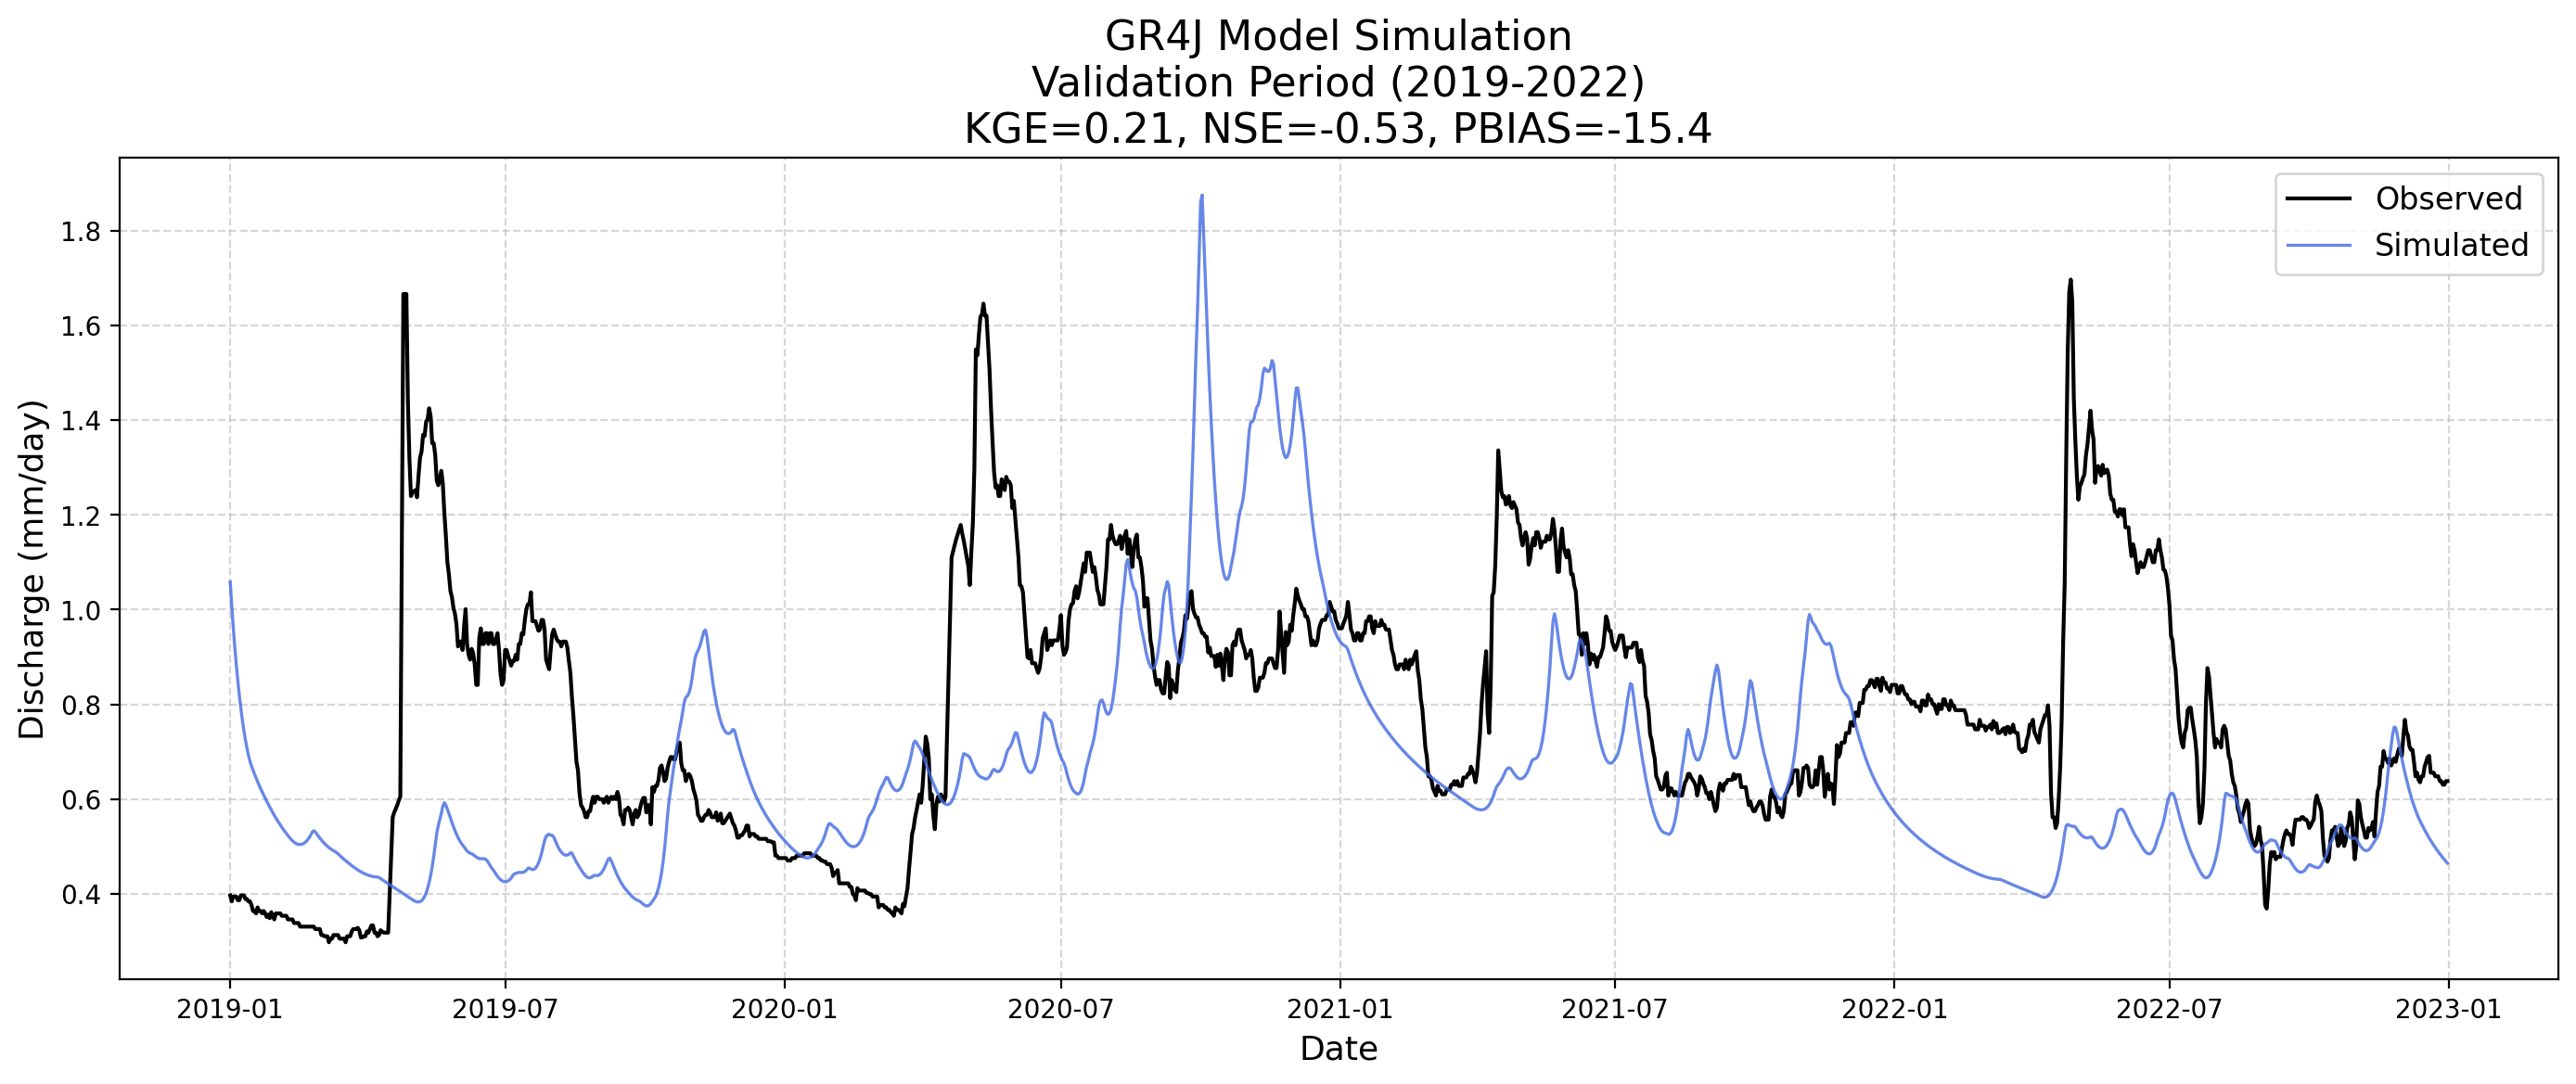

In [14]:
# Analyze the Pareto front
pareto_df = analyze_pareto_front(pareto_trials)
logger.info(f"Found {len(pareto_trials)} Pareto-optimal solutions")

# Method 1: Hydrological focus (emphasize KGE and NSE)
hydro_weights = {"KGE": 0.5, "NSE": 0.5, "logNSE": 0.5, "PBIAS": 0.03, "RMSE": 0.02}
best_hydro = select_best_trial_weighted(pareto_trials, hydro_weights, "weighted_sum")

# Method 2: TOPSIS with balanced weights
balanced_weights = {"KGE": 0.3, "NSE": 0.3, "logNSE": 0.2, "PBIAS": 0.1, "RMSE": 0.1}
best_topsis = select_best_trial_weighted(pareto_trials, balanced_weights, "topsis")

# Method 3: Compromise programming with low flow focus
lowflow_weights = {"KGE": 0.25, "NSE": 0.25, "logNSE": 0.35, "PBIAS": 0.1, "RMSE": 0.05}
best_compromise = select_best_trial_weighted(pareto_trials, lowflow_weights, "compromise")

gr4j_validation = gr4j_data.loc[validation_period[0] : validation_period[1], :]
# Run the GR4J model with the best parameters
q_sim = gr4j.simulation(gr4j_validation, list(best_hydro.params.values()))
# Evaluate the model performance
metrics = evaluate_model(gr4j_validation["q_mm_day"].values, q_sim)

plot_observed_vs_simulated(
    gr4j_validation["q_mm_day"].values,
    q_sim,
    index=gr4j_validation.index,
    title="GR4J Model Simulation\nValidation Period (2019-2022)\nKGE={:.2f}, NSE={:.2f}, PBIAS={:.1f}".format(
        metrics["KGE"], metrics["NSE"], metrics["PBIAS"]
    ),
)

In [ ]:
from src.readers.geom_reader import load_geodata
from src.readers.hydro_data_reader import find_valid_gauges
from src.models.gr4j.model import simulation as gr4j_simulation

validation_period = ("2019-01-01", "2022-12-31")
selection_period = ("2018-01-01", "2022-12-31")

e_obs_ws, e_obs_gauges = load_geodata(folder_depth="..")
basemap_data = gpd.read_file("../data/Geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../data/Geometry/basin_districts_2024.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
basin_districts.drop([26, 27], inplace=True)  # Drop districts with no gauges

logger.info("Finding gauges with valid data...")
full_gauges, partial_gauges = find_valid_gauges(e_obs_ws, Path("../data/HydroFiles"))

METEO_DATASETS = ["meteo_ru_nc_02", "e_obs", "era5_land", "mswep"]
for meteo_dataset in METEO_DATASETS:
    for gauge_id in full_gauges:
        # Get the relevant data and parameters for this dataset
        with open(
            f"../data/res/gr4j_optuna/{gauge_id}/{gauge_id}_{meteo_dataset}/best_parameters.json"
        ) as f:
            gr4j_params = json.load(f)

        # Load hydro data
        hydro_file = pd.read_csv(
            f"../data/HydroFiles/{gauge_id}.csv", parse_dates=["date"], index_col="date"
        )[["q_mm_day", "lvl_sm"]]

        # Load and process meteo data based on dataset
        if meteo_dataset == "mswep":
            with xr.open_dataset(
                f"../data/MeteoData/ProcessedGauges/{meteo_dataset}/res/{gauge_id}.nc"
            ) as ds:
                mswep_file = ds.to_dataframe()
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/era5_land/res/{gauge_id}.nc") as ds:
                meteo_file = ds.to_dataframe()
            meteo_file.loc[:, "prcp"] = mswep_file.loc[:, "prcp"]
        else:
            with xr.open_dataset(
                f"../data/MeteoData/ProcessedGauges/{meteo_dataset}/res/{gauge_id}.nc"
            ) as ds:
                meteo_file = ds.to_dataframe()

        if "t_mean" not in meteo_file.columns:
            meteo_file["t_mean"] = (meteo_file["t_max"] + meteo_file["t_min"]) / 2

        # Get gauge location for PET calculation
        point_geom = e_obs_gauges.loc[gauge_id, "geometry"]
        latitude = float(point_geom.y)

        # Prepare data for simulation
        gr4j_data = pd.concat([hydro_file, meteo_file], axis=1).loc["2008":, :]
        t_mean_list = gr4j_data["t_mean"].tolist()
        day_of_year_list = [int(d) for d in gr4j_data["day_of_year"].tolist()]
        gr4j_data["pet_mm_day"] = pet_oudin(t_mean_list, day_of_year_list, latitude)
        gr4j_data = gr4j_data.loc[selection_period[0] : selection_period[1], :]
        # Run simulation
        gr4j_data["q_pred"] = gr4j_simulation(data=gr4j_data, params=list(gr4j_params.values()))
        exmp_data = gr4j_data.loc[validation_period[0] : validation_period[1], ["q_mm_day", "q_pred"]]
        # Calculate metrics for this simulation
        gauge_metric = evaluate_model(observed=exmp_data["q_mm_day"], simulated=exmp_data["q_pred"])
        with open(
            f"../data/res/gr4j_optuna/{gauge_id}/{gauge_id}_{meteo_dataset}/metrics.json", "w"
        ) as f:
            json.dump(gauge_metric, f)


### mswep

In [ ]:
q_obs = gr4j_data["q_mm_day"].loc[validation_period[0] : validation_period[1]].values
q_test = gr4j.simulation(gr4j_data.loc[validation_period[0] : validation_period[1], :], model_params)
# Plot the two series
plot_observed_vs_simulated(
    observed=q_obs,
    simulated=q_test,
    index=gr4j_data.loc[validation_period[0] : validation_period[1]].index,
    title="GR4J Model: Observed vs Simulated Discharge",
)


In [ ]:
nash_sutcliffe_efficiency(observed=q_obs, simulated=q_test)


### meteo stations

In [ ]:
q_obs = gr4j_data["q_mm_day"].loc[validation_period[0] : validation_period[1]].values
q_test = gr4j.simulation(gr4j_data.loc[validation_period[0] : validation_period[1], :], model_params)
# Plot the two series
plot_observed_vs_simulated(
    observed=q_obs,
    simulated=q_test,
    index=gr4j_data.loc[validation_period[0] : validation_period[1]].index,
    title="GR4J Model: Observed vs Simulated Discharge",
)


In [ ]:
nash_sutcliffe_efficiency(observed=q_obs, simulated=q_test)


### e-obs

In [ ]:
q_obs = gr4j_data["q_mm_day"].loc[validation_period[0] : validation_period[1]].values
q_test = gr4j.simulation(gr4j_data.loc[validation_period[0] : validation_period[1], :], model_params)
# Plot the two series
plot_observed_vs_simulated(
    observed=q_obs,
    simulated=q_test,
    index=gr4j_data.loc[validation_period[0] : validation_period[1]].index,
    title="GR4J Model: Observed vs Simulated Discharge",
)


In [ ]:
nash_sutcliffe_efficiency(observed=q_obs, simulated=q_test)


### ERA5-Land

In [ ]:
q_obs = gr4j_data["q_mm_day"].loc[validation_period[0] : validation_period[1]].values
q_test = gr4j.simulation(gr4j_data.loc[validation_period[0] : validation_period[1], :], model_params)
# Plot the two series
plot_observed_vs_simulated(
    observed=q_obs,
    simulated=q_test,
    index=gr4j_data.loc[validation_period[0] : validation_period[1]].index,
    title="GR4J Model: Observed vs Simulated Discharge",
)


In [ ]:
kling_gupta_efficiency(observed=q_obs, simulated=q_test)